## Deep Learning strategy

In [6]:
from DNNModel import *
import time
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import tpqoa
api = tpqoa.tpqoa("oanda.cfg")

def get_data(symbol, tf):
    ''' Download static data from folder
    '''
    data = api.get_history(instrument = symbol, start = '2020-01-01', end = '2021-03-01',
                granularity = tf, price = "M")
    data = data.drop(['o','h','l','complete'], axis=1)
    
    #data = pd.read_csv("Data/{}_{}.csv".format(symbol, tf), parse_dates = ["time"], index_col = "time")
    #data = data.drop(['o','h','l'], axis = 1)

    data = data.rename(columns={"c":symbol})

    data["returns"] = np.log(data[symbol]/data[symbol].shift())
    return data

def get_features(window, lags):
    '''Function go get features. Require dataframe,
    number of windows for rolling calculations and lags to create additional features.
    '''
    df = data.copy()
    # Specify market direction
    df["dir"] = np.where(df["returns"] > 0, 1, 0)
    # Specify any technical indicators as feature
    # Distance between two smas
    df["sma"] = df[symbol].rolling(window).mean() - df[symbol].rolling(window*2).mean()
    # Distance between current price and sma
    df["boll"] = (df[symbol] - df[symbol].rolling(window).mean()) / df[symbol].rolling(window).std()
    # Distance between rolling min/max prices and current price
    df["min"] = df[symbol].rolling(window).min() / df[symbol] - 1
    df["max"] = df[symbol].rolling(window).max() / df[symbol] - 1
    # Rolling mean returns
    df["mom"] = df["returns"].rolling(3).mean()
    # Volatility feature
    df["vol"] = df["returns"].rolling(window).std()
    df.dropna(inplace = True)
    
    # Adding feature lags
    cols = []
    features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]
    
    for f in features:
        for lag in range(1, lags + 1):
            col = "{}_lag_{}".format(f, lag)
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace = True)
    return cols, df

def prepare_data():
    ''' Splitting data into train and test set. Feature standardization.
    Returns train, test, mu, std, train_s, test_s
    '''
    train = data[:"2021-01-01"]
    test = data["2021-01-01":]
    # Feature standardization
    # train set parameters (mu, std) for standardization
    mu, std = train.mean(), train.std()
    # standardization of train set features
    train_s = (train - mu) / std
    # standardization of test set features by train set parameters
    test_s = (test - mu) / std 

    return train, test, mu, std, train_s, test_s

def check_model(hl, hu, dropout, epochs):
    '''Function to train and test the model.
    '''
    start_time = time.time()
    # Prepare the model
    set_seeds(100)
    model = create_model(hl = hl, hu = hu, dropout = dropout, input_dim = len(cols))
    model.fit(x = train_s[cols], y = train["dir"], epochs = epochs, verbose = False,
              validation_split = 0.2, shuffle = False, class_weight = cw(train))
    # Train the model
    train_accuracy = model.evaluate(train_s[cols], train["dir"]) # evaluate the fit on the train set
    train_pred = model.predict(train_s[cols]) # prediction (probabilities)
    plt.hist(train_pred, bins = 50)
    plt.show()
    print("The accuracy of the model on TRAIN set is {}%".format(round(train_accuracy[1]*100,2)))
    
    # Test the model
    test_accuracy = model.evaluate(test_s[cols], test["dir"])
    test_pred = model.predict(test_s[cols])
    plt.hist(test_pred, bins = 50)
    print("The accuracy of the model on TEST set is {}%".format(round(test_accuracy[1]*100,2)))
    print("It took {} minutes to train and test the model".format(round((time.time() - start_time)/60,1)))
    
    return test_pred

def check_outcome():
    # Create position column which will indicate if trade should be taken
    test["proba"] = prediction
    test["position"] = np.where(test.proba < 0.47, -1, np.nan) # 1. Short where probability < 0.47
    test["position"] = np.where(test.proba > 0.53, 1, test.position) # 2. Long where probability > 0.53

    # Add the busy trading hours
    test.index = test.index.tz_localize("UTC")
    test["NYTime"] = test.index.tz_convert("America/New_York")
    test["hour"] = test.NYTime.dt.hour
    test.position = np.where(~test.hour.between(2, 12), 0, test.position) # 3. Neutral in non-busy hours
    test.loc[:,'position'] = test.position.ffill().fillna(0) # 4. Hold position in other cases

    # Calculate returns of the strategy
    test["strategy"] = test["position"] * test["returns"]
    test["creturns"] = test["returns"].cumsum().apply(np.exp)
    test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)

    # Add cost of trading
    test["trades"] = test.position.diff().abs() # How many position changes
    test["strategy_net"] = test.strategy - test.trades * spread
    test["cstrategy_net"] = test["strategy_net"].cumsum().apply(np.exp)
    
    # Variables to use for comparison
    nr_trades = test.trades.where(test.trades != 0).dropna().sum()
    total_outcome = round((test.cstrategy_net[-1] - 1)*100,2)
    
    # Plot te three returns lines
    test[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12, 8))
    plt.show()
    print("The cumulative return of the strategy is {}% made on {} trades".format(total_outcome, nr_trades))

In [2]:
import json
# Import prepared dictionary which contains average spreads for all assets
with open('Data\spreads.json', 'r') as fp:
    spreads = json.load(fp)

# Prepare instruments list from spreads file
instruments_list = []
for key in spreads:
    instruments_list.append(key)
instruments_list = instruments_list[1:]

In [9]:
symbol = "EUR_USD"
tf = "M15"

window = 30
lags = 10

hl = 5
hu = 100
dropout = True
epochs = 50

spread = spreads[symbol]/2

24881/24881 [==============================] - 1s 47us/step


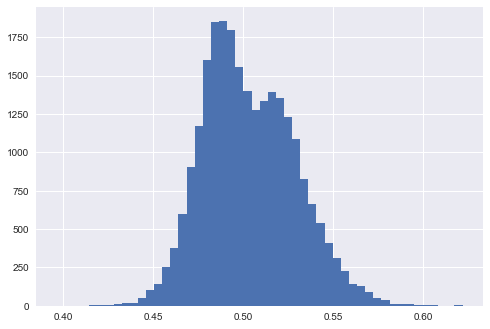

The accuracy of the model on TRAIN set is 54.37%
3848/3848 [==============================] - 0s 50us/step
The accuracy of the model on TEST set is 51.35%
It took 3.9 minutes to train and test the model


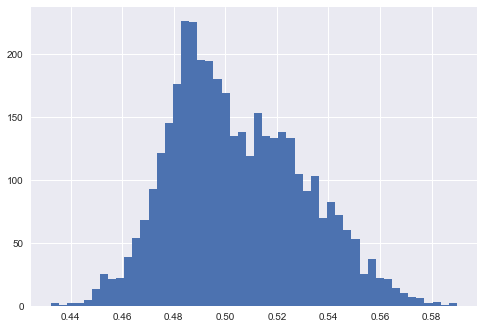

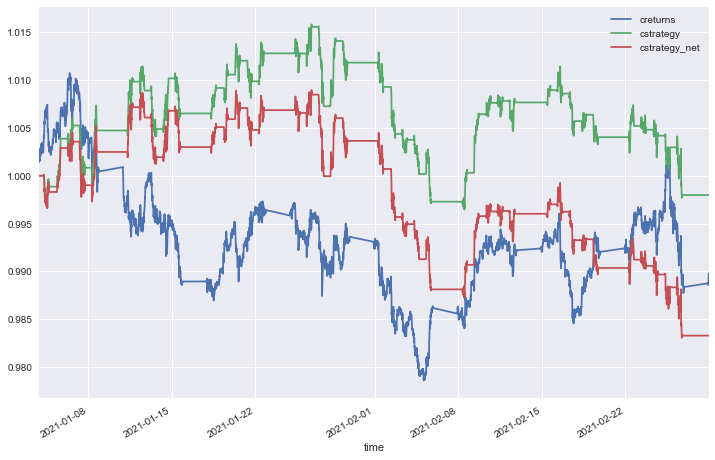

The cumulative return of the strategy is -1.67%


In [15]:
data = get_data(symbol, tf)

cols, data = get_features(window, lags)

train, test, mu, std, train_s, test_s = prepare_data()

prediction = check_model(hl, hu, dropout, epochs)

check_outcome()

In [40]:
test.trades.where(test.trades != 0).dropna().value_counts()

1.00000    80
2.00000    66
Name: trades, dtype: int64

In [41]:
test.trades.where(test.trades != 0).dropna().sum()

212.0

- table with acc on test and train, nr of trades, return and cum return
- get the best sma values and use in model
- parameters of the model
- saving the model

### Saving Model and Parameters

In [ ]:
import pickle

In [ ]:
model.save("DNN_model")
params = {"mu":mu, "std":std}
pickle.dump(params, open("params.pkl", "wb"))